## 1. Prepare data and voxelMorph code



In [1]:
import voxelmorph2d as vm2d
import voxelmorph3d as vm3d

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
from skimage.filters import threshold_otsu
import multiprocessing as mp
from tqdm import tqdm
import gc
import time
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable

use_gpu = torch.cuda.is_available()

In [2]:
import os
import cv2

In [3]:
import importlib
importlib.reload(vm2d)

<module 'voxelmorph2d' from '/Users/nastya/Documents/ucu/thesis/voxelmorph/voxelmorph2d.py'>

## 2. Preparing GANs

In [ ]:
def list_of_image_tuples(data_path, get_type='mask'):
    image_tuples = []
    mask_tuples = []

    for folder in sorted(os.listdir(data_path)):
        if folder.startswith('pairs'):
            pair_folder = os.path.join(data_path, folder)

            if os.path.exists(os.path.join(pair_folder, 'target_image.jpg')) and \
               os.path.exists(os.path.join(pair_folder, 'source_images')):

                target_image_path = os.path.join(pair_folder, 'target_image.jpg')
                source_image_folder = os.path.join(pair_folder, 'source_images')

                for source_image in sorted(os.listdir(source_image_folder)):
                    source_image_path = os.path.join(source_image_folder, source_image)
                    image_tuples.append((target_image_path, source_image_path))

            if os.path.exists(os.path.join(pair_folder, 'target_mask.jpg')) and \
               os.path.exists(os.path.join(pair_folder, 'source_masks')):

                target_mask_path = os.path.join(pair_folder, 'target_mask.jpg')
                source_mask_folder = os.path.join(pair_folder, 'source_masks')

                for source_mask in sorted(os.listdir(source_mask_folder)):
                    source_mask_path = os.path.join(source_mask_folder, source_mask)
                    mask_tuples.append((target_mask_path, source_mask_path))

    if get_type == 'mask':
        return mask_tuples

    return image_tuples

In [ ]:
pairs = list_of_image_tuples('/content/drive_data', 'mask')
pairs[0:5]

[('/content/drive_data/pairs_0/target_mask.jpg',
  '/content/drive_data/pairs_0/source_masks/source_mask_0.jpg'),
 ('/content/drive_data/pairs_0/target_mask.jpg',
  '/content/drive_data/pairs_0/source_masks/source_mask_1.jpg'),
 ('/content/drive_data/pairs_0/target_mask.jpg',
  '/content/drive_data/pairs_0/source_masks/source_mask_10.jpg'),
 ('/content/drive_data/pairs_0/target_mask.jpg',
  '/content/drive_data/pairs_0/source_masks/source_mask_11.jpg'),
 ('/content/drive_data/pairs_0/target_mask.jpg',
  '/content/drive_data/pairs_0/source_masks/source_mask_12.jpg')]

In [ ]:
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

train_set, remaining_set = train_test_split(pairs, test_size=(validation_ratio + test_ratio), random_state=42)
validation_set, test_set = train_test_split(remaining_set, test_size=test_ratio / (validation_ratio + test_ratio), random_state=42)

In [4]:
class DriveDataset(data.Dataset):
    def __init__(self, pairs, img_size=(292, 282)):
        self.pairs = pairs
        self.img_size = img_size

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        target_path = self.pairs[idx][0]
        source_path = self.pairs[idx][1]

        target_image = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)
        source_image = cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)

        target_image = cv2.resize(target_image, (256, 256))
        source_image = cv2.resize(source_image, (256, 256))

        target_image = (target_image > 127).view(np.uint8) * 255
        source_image = (source_image > 127).view(np.uint8) * 255

        target_image = torch.Tensor(target_image)
        source_image = torch.Tensor(source_image)

        return target_image, source_image

In [ ]:
train_data = DriveDataset(train_set)
validation_data = DriveDataset(validation_set)
test_data = DriveDataset(test_set)

In [ ]:
batch_size = 32

training_generator = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_generator = data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

In [5]:
class VoxelMorph():
    """
    VoxelMorph Class is a higher level interface for both 2D and 3D
    Voxelmorph classes. It makes training easier and is scalable.
    """

    def __init__(self, input_dims, is_2d=False, use_gpu=False):
        self.dims = input_dims
        if is_2d:
            self.vm = vm2d
            self.voxelmorph = vm2d.VoxelMorph2d(input_dims[0] * 2, use_gpu)
        else:
            self.vm = vm3d
            self.voxelmorph = vm3d.VoxelMorph3d(input_dims[0] * 2, use_gpu)
        self.optimizer = optim.SGD(self.voxelmorph.parameters(), lr=1e-4, momentum=0.99)
        self.params = {'batch_size': 3,
                       'shuffle': True,
                       'num_workers': 6,
                       'worker_init_fn': np.random.seed(42)
                       }
        self.device = torch.device("cuda:0" if use_gpu else "cpu")

    def check_dims(self, x):
        try:
            if x.shape[1:] == self.dims:
                return
            else:
                raise TypeError
        except TypeError as e:
            print("Invalid Dimension Error. The supposed dimension is ",
                  self.dims, "But the dimension of the input is ", x.shape[1:])

    def forward(self, x):
        self.check_dims(x)
        return voxelmorph(x)

    def calculate_loss(self, y, ytrue, n=9, lamda=0.01, is_training=True):
        loss = self.vm.vox_morph_loss(y, ytrue, n, lamda)
        return loss

    def train_model(self, batch_moving, batch_fixed, n=9, lamda=0.01, return_metric_score=True):
        self.optimizer.zero_grad()
        batch_fixed, batch_moving = batch_fixed.to(self.device), batch_moving.to(self.device)
        registered_image, _ = self.voxelmorph(batch_moving, batch_fixed)
        print(batch_fixed.shape)
        train_loss = self.calculate_loss(registered_image, batch_fixed, n, lamda)
        train_loss.backward()
        self.optimizer.step()
        if return_metric_score:
            train_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return train_loss, train_dice_score
        return train_loss

    def get_test_loss(self, batch_moving, batch_fixed, n=9, lamda=0.01):
        with torch.set_grad_enabled(False):
            registered_image, _ = self.voxelmorph(batch_moving, batch_fixed)
            val_loss = self.vm.vox_morph_loss(registered_image, batch_fixed, n, lamda)
            val_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return val_loss, val_dice_score

## 3. GANs

In [6]:
def add_conv_stage(dim_in, dim_out, kernel_size = 4, stride = 2, padding = 1, bias = False):
  return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.2, inplace=True)
  )

  ## Define discriminator
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            add_conv_stage(64, 128),
            add_conv_stage(128, 256),
            add_conv_stage(256, 512),
            nn.Conv2d(512, 1, 4,2,1, bias = False),
            nn.LeakyReLU(0.2),
            nn.Sigmoid()
        )

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        return self.layers(input)


In [7]:
## Generator
vm = VoxelMorph((1, 256, 256), is_2d=True,  use_gpu=use_gpu)

generator = vm.voxelmorph


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
D = discriminator()
G = generator

lr_g = 2e-4
lr_d = 1e-4

D_losses = []
G_losses = []
G_losses_total = []

BCELoss = nn.BCELoss()
MSELoss = nn.MSELoss()
KLDiveLoss = nn.KLDivLoss()

SmoothingLoss = vm2d.smooothing_loss

G_optimizer = optim.Adam(G.parameters(), lr=lr_g, betas=(.5, 0.999))
# D_optimizer = optim.Adam(D.parameters(), lr=lr_d, betas=(.5, 0.999))
D_optimizer = optim.SGD(D.parameters(), lr=lr_d)

if use_gpu:
    G = G.cuda()
    D = D.cuda()
D.apply(weights_init)
G.apply(weights_init)

VoxelMorph2d(
  (unet): UNet(
    (conv_encode1): Sequential(
      (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2,

In [ ]:
epochs = 80
train_interval = 5
for epoch in tqdm(range(epochs)):

    for batch_moving, batch_fixed in training_generator:

        mini_batch = batch_moving.shape[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        if use_gpu:
            y_real_ = y_real_.cuda()
            y_fake_ = y_fake_.cuda()
            batch_moving = batch_moving.cuda()
            batch_fixed = batch_fixed.cuda()

        batch_fixed = batch_fixed.unsqueeze(3)
        batch_moving = batch_moving.unsqueeze(3)

        batch_fixed_reorder = batch_fixed.permute(0, 3, 1, 2)
        batch_moving_reorder = batch_moving.permute(0, 3, 1, 2)

        # Train discriminator D
        D.zero_grad()
        # D_real = D(batch_moving_reorder).view(-1)

        D_real = torch.mean(D(batch_moving_reorder), dim=(1, 2, 3))

        D_real_loss = BCELoss(D_real, Variable(y_real_))
        D_real_loss.backward()

        with torch.no_grad():
            dat_fake, _ = G(batch_moving, batch_fixed)
        dat_fake_reorder = dat_fake.permute(0, 3, 1, 2)

        # D_fake = D(dat_fake_reorder).view(-1)
        D_fake = torch.mean(D(dat_fake_reorder), dim=(1, 2, 3))

        D_fake_loss = BCELoss(D_fake, Variable(y_fake_))
        D_fake_loss.backward()

        D_optimizer.step()
        D_train_loss = D_real_loss + D_fake_loss
        D_losses.append(D_train_loss.data.item())

        # Train generator G
        for iter in range(train_interval):

            G.zero_grad()
            dat_fake, _ = G(batch_moving, batch_fixed)
            dat_fake_reorder = dat_fake.permute(0, 3, 1, 2)

            with torch.no_grad():
            #   D_fake = D(dat_fake_reorder).view(-1)
                D_fake = torch.mean(D(dat_fake_reorder), dim=(1, 2, 3))
            G_train_loss = BCELoss(D_fake, Variable(y_real_))
            G_train_loss_total = G_train_loss + 1e-3*MSELoss(dat_fake, batch_fixed)+1e-3*SmoothingLoss(dat_fake)

            G_train_loss_total.backward()
            G_optimizer.step()
            G_losses.append(G_train_loss.data.item())
            G_losses_total.append(G_train_loss_total.data.item())

    print('[%d/%d] - loss_d: %.3f, loss_g: %.3f, loss_g_total: %.3f' % ((epoch + 1), epochs,
                                                    torch.mean(torch.FloatTensor(D_losses)),
                                                    torch.mean(torch.FloatTensor(G_losses)),
                                                    torch.mean(torch.FloatTensor(G_losses_total))))


  1%|▏         | 1/80 [00:35<46:13, 35.11s/it]

[1/80] - loss_d: 1.393, loss_g: 0.592, loss_g_total: 7.893


  2%|▎         | 2/80 [01:09<44:58, 34.60s/it]

[2/80] - loss_d: 1.387, loss_g: 0.596, loss_g_total: 7.101


  4%|▍         | 3/80 [01:44<44:36, 34.76s/it]

[3/80] - loss_d: 1.386, loss_g: 0.597, loss_g_total: 6.671


  5%|▌         | 4/80 [02:18<43:42, 34.50s/it]

[4/80] - loss_d: 1.384, loss_g: 0.598, loss_g_total: 6.375


  6%|▋         | 5/80 [02:52<43:08, 34.51s/it]

[5/80] - loss_d: 1.384, loss_g: 0.599, loss_g_total: 6.161


  8%|▊         | 6/80 [03:27<42:29, 34.46s/it]

[6/80] - loss_d: 1.383, loss_g: 0.600, loss_g_total: 5.995


  9%|▉         | 7/80 [04:01<41:51, 34.41s/it]

[7/80] - loss_d: 1.382, loss_g: 0.600, loss_g_total: 5.865


 10%|█         | 8/80 [04:35<41:16, 34.40s/it]

[8/80] - loss_d: 1.381, loss_g: 0.601, loss_g_total: 5.756


 11%|█▏        | 9/80 [05:10<40:44, 34.43s/it]

[9/80] - loss_d: 1.380, loss_g: 0.602, loss_g_total: 5.657


 12%|█▎        | 10/80 [05:44<40:11, 34.45s/it]

[10/80] - loss_d: 1.380, loss_g: 0.603, loss_g_total: 5.571


 14%|█▍        | 11/80 [06:19<39:36, 34.45s/it]

[11/80] - loss_d: 1.379, loss_g: 0.604, loss_g_total: 5.490


 15%|█▌        | 12/80 [06:53<39:02, 34.44s/it]

[12/80] - loss_d: 1.378, loss_g: 0.604, loss_g_total: 5.418


 16%|█▋        | 13/80 [07:28<38:26, 34.42s/it]

[13/80] - loss_d: 1.378, loss_g: 0.605, loss_g_total: 5.350


 18%|█▊        | 14/80 [08:02<37:51, 34.41s/it]

[14/80] - loss_d: 1.377, loss_g: 0.606, loss_g_total: 5.287


 19%|█▉        | 15/80 [08:37<37:16, 34.41s/it]

[15/80] - loss_d: 1.377, loss_g: 0.606, loss_g_total: 5.228


 20%|██        | 16/80 [09:11<36:44, 34.44s/it]

[16/80] - loss_d: 1.376, loss_g: 0.607, loss_g_total: 5.176


 21%|██▏       | 17/80 [09:46<36:11, 34.47s/it]

[17/80] - loss_d: 1.376, loss_g: 0.608, loss_g_total: 5.128


 22%|██▎       | 18/80 [10:20<35:38, 34.48s/it]

[18/80] - loss_d: 1.375, loss_g: 0.608, loss_g_total: 5.081


 24%|██▍       | 19/80 [10:54<35:02, 34.46s/it]

[19/80] - loss_d: 1.375, loss_g: 0.609, loss_g_total: 5.037


 25%|██▌       | 20/80 [11:29<34:25, 34.43s/it]

[20/80] - loss_d: 1.374, loss_g: 0.610, loss_g_total: 4.995


 26%|██▋       | 21/80 [12:03<33:50, 34.41s/it]

[21/80] - loss_d: 1.374, loss_g: 0.610, loss_g_total: 4.957


 28%|██▊       | 22/80 [12:38<33:15, 34.40s/it]

[22/80] - loss_d: 1.373, loss_g: 0.611, loss_g_total: 4.921


 29%|██▉       | 23/80 [13:12<32:41, 34.42s/it]

[23/80] - loss_d: 1.373, loss_g: 0.612, loss_g_total: 4.887


 30%|███       | 24/80 [13:47<32:08, 34.44s/it]

[24/80] - loss_d: 1.373, loss_g: 0.612, loss_g_total: 4.855


 31%|███▏      | 25/80 [14:21<31:34, 34.44s/it]

[25/80] - loss_d: 1.372, loss_g: 0.613, loss_g_total: 4.825


 32%|███▎      | 26/80 [14:55<31:00, 34.46s/it]

[26/80] - loss_d: 1.372, loss_g: 0.613, loss_g_total: 4.796


 34%|███▍      | 27/80 [15:30<30:26, 34.46s/it]

[27/80] - loss_d: 1.371, loss_g: 0.614, loss_g_total: 4.769


 35%|███▌      | 28/80 [16:04<29:50, 34.44s/it]

[28/80] - loss_d: 1.371, loss_g: 0.615, loss_g_total: 4.742


 36%|███▋      | 29/80 [16:39<29:16, 34.44s/it]

[29/80] - loss_d: 1.370, loss_g: 0.615, loss_g_total: 4.717


 38%|███▊      | 30/80 [17:13<28:41, 34.42s/it]

[30/80] - loss_d: 1.370, loss_g: 0.616, loss_g_total: 4.693


 39%|███▉      | 31/80 [17:48<28:06, 34.41s/it]

[31/80] - loss_d: 1.370, loss_g: 0.616, loss_g_total: 4.669


 40%|████      | 32/80 [18:22<27:33, 34.44s/it]

[32/80] - loss_d: 1.369, loss_g: 0.617, loss_g_total: 4.647


 41%|████▏     | 33/80 [18:57<26:59, 34.46s/it]

[33/80] - loss_d: 1.369, loss_g: 0.617, loss_g_total: 4.626


 42%|████▎     | 34/80 [19:31<26:25, 34.47s/it]

[34/80] - loss_d: 1.368, loss_g: 0.618, loss_g_total: 4.605


 44%|████▍     | 35/80 [20:06<25:51, 34.48s/it]

[35/80] - loss_d: 1.368, loss_g: 0.619, loss_g_total: 4.586


 45%|████▌     | 36/80 [20:40<25:17, 34.48s/it]

[36/80] - loss_d: 1.367, loss_g: 0.619, loss_g_total: 4.566


 46%|████▋     | 37/80 [21:15<24:42, 34.48s/it]

[37/80] - loss_d: 1.367, loss_g: 0.620, loss_g_total: 4.547


 48%|████▊     | 38/80 [21:49<24:08, 34.48s/it]

[38/80] - loss_d: 1.366, loss_g: 0.620, loss_g_total: 4.529


 49%|████▉     | 39/80 [22:23<23:32, 34.46s/it]

[39/80] - loss_d: 1.366, loss_g: 0.621, loss_g_total: 4.513


 50%|█████     | 40/80 [22:58<22:57, 34.45s/it]

[40/80] - loss_d: 1.365, loss_g: 0.621, loss_g_total: 4.496


 51%|█████▏    | 41/80 [23:32<22:23, 34.45s/it]

[41/80] - loss_d: 1.365, loss_g: 0.621, loss_g_total: 4.480


 52%|█████▎    | 42/80 [24:07<21:49, 34.46s/it]

[42/80] - loss_d: 1.364, loss_g: 0.622, loss_g_total: 4.465


 54%|█████▍    | 43/80 [24:41<21:15, 34.46s/it]

[43/80] - loss_d: 1.364, loss_g: 0.622, loss_g_total: 4.450


 55%|█████▌    | 44/80 [25:16<20:40, 34.46s/it]

[44/80] - loss_d: 1.364, loss_g: 0.623, loss_g_total: 4.436


 56%|█████▋    | 45/80 [25:50<20:06, 34.47s/it]

[45/80] - loss_d: 1.363, loss_g: 0.623, loss_g_total: 4.422


 57%|█████▊    | 46/80 [26:25<19:31, 34.46s/it]

[46/80] - loss_d: 1.363, loss_g: 0.624, loss_g_total: 4.408


 59%|█████▉    | 47/80 [26:59<18:57, 34.45s/it]

[47/80] - loss_d: 1.362, loss_g: 0.624, loss_g_total: 4.395


 60%|██████    | 48/80 [27:34<18:22, 34.45s/it]

[48/80] - loss_d: 1.362, loss_g: 0.625, loss_g_total: 4.382


 61%|██████▏   | 49/80 [28:08<17:48, 34.45s/it]

[49/80] - loss_d: 1.361, loss_g: 0.625, loss_g_total: 4.369


 62%|██████▎   | 50/80 [28:42<17:12, 34.42s/it]

[50/80] - loss_d: 1.361, loss_g: 0.625, loss_g_total: 4.357


 64%|██████▍   | 51/80 [29:17<16:37, 34.41s/it]

[51/80] - loss_d: 1.360, loss_g: 0.626, loss_g_total: 4.345


 65%|██████▌   | 52/80 [29:51<16:03, 34.42s/it]

[52/80] - loss_d: 1.360, loss_g: 0.626, loss_g_total: 4.334


 66%|██████▋   | 53/80 [30:26<15:29, 34.44s/it]

[53/80] - loss_d: 1.360, loss_g: 0.627, loss_g_total: 4.322


 68%|██████▊   | 54/80 [31:00<14:55, 34.44s/it]

[54/80] - loss_d: 1.359, loss_g: 0.627, loss_g_total: 4.310


 69%|██████▉   | 55/80 [31:34<14:20, 34.43s/it]

[55/80] - loss_d: 1.359, loss_g: 0.627, loss_g_total: 4.300


 70%|███████   | 56/80 [32:09<13:45, 34.41s/it]

[56/80] - loss_d: 1.358, loss_g: 0.628, loss_g_total: 4.289


 71%|███████▏  | 57/80 [32:43<13:11, 34.41s/it]

[57/80] - loss_d: 1.358, loss_g: 0.628, loss_g_total: 4.279


 72%|███████▎  | 58/80 [33:18<12:36, 34.38s/it]

[58/80] - loss_d: 1.357, loss_g: 0.628, loss_g_total: 4.268


 74%|███████▍  | 59/80 [33:52<12:01, 34.37s/it]

[59/80] - loss_d: 1.357, loss_g: 0.629, loss_g_total: 4.259


 75%|███████▌  | 60/80 [34:26<11:27, 34.36s/it]

[60/80] - loss_d: 1.356, loss_g: 0.629, loss_g_total: 4.249


 76%|███████▋  | 61/80 [35:01<10:53, 34.38s/it]

[61/80] - loss_d: 1.356, loss_g: 0.630, loss_g_total: 4.239


 78%|███████▊  | 62/80 [35:35<10:19, 34.39s/it]

[62/80] - loss_d: 1.356, loss_g: 0.630, loss_g_total: 4.230


 79%|███████▉  | 63/80 [36:10<09:45, 34.42s/it]

[63/80] - loss_d: 1.355, loss_g: 0.630, loss_g_total: 4.221


 80%|████████  | 64/80 [36:44<09:10, 34.42s/it]

[64/80] - loss_d: 1.355, loss_g: 0.631, loss_g_total: 4.212


 81%|████████▏ | 65/80 [37:18<08:35, 34.40s/it]

[65/80] - loss_d: 1.354, loss_g: 0.631, loss_g_total: 4.203


 82%|████████▎ | 66/80 [37:53<08:01, 34.39s/it]

[66/80] - loss_d: 1.354, loss_g: 0.631, loss_g_total: 4.195


 84%|████████▍ | 67/80 [38:27<07:27, 34.39s/it]

[67/80] - loss_d: 1.353, loss_g: 0.632, loss_g_total: 4.186


 85%|████████▌ | 68/80 [39:02<06:52, 34.40s/it]

[68/80] - loss_d: 1.353, loss_g: 0.632, loss_g_total: 4.178


 86%|████████▋ | 69/80 [39:36<06:18, 34.41s/it]

[69/80] - loss_d: 1.353, loss_g: 0.632, loss_g_total: 4.170


 88%|████████▊ | 70/80 [40:10<05:44, 34.42s/it]

[70/80] - loss_d: 1.352, loss_g: 0.632, loss_g_total: 4.162


 89%|████████▉ | 71/80 [40:45<05:09, 34.40s/it]

[71/80] - loss_d: 1.352, loss_g: 0.633, loss_g_total: 4.154


 90%|█████████ | 72/80 [41:19<04:35, 34.40s/it]

[72/80] - loss_d: 1.351, loss_g: 0.633, loss_g_total: 4.147


 91%|█████████▏| 73/80 [41:53<04:00, 34.38s/it]

[73/80] - loss_d: 1.351, loss_g: 0.633, loss_g_total: 4.139


 92%|█████████▎| 74/80 [42:28<03:26, 34.37s/it]

[74/80] - loss_d: 1.350, loss_g: 0.634, loss_g_total: 4.132


 94%|█████████▍| 75/80 [43:02<02:51, 34.38s/it]

[75/80] - loss_d: 1.350, loss_g: 0.634, loss_g_total: 4.125


 95%|█████████▌| 76/80 [43:37<02:17, 34.39s/it]

[76/80] - loss_d: 1.350, loss_g: 0.634, loss_g_total: 4.118


 96%|█████████▋| 77/80 [44:11<01:43, 34.40s/it]

[77/80] - loss_d: 1.349, loss_g: 0.634, loss_g_total: 4.111


 98%|█████████▊| 78/80 [44:46<01:08, 34.42s/it]

[78/80] - loss_d: 1.349, loss_g: 0.635, loss_g_total: 4.104


 99%|█████████▉| 79/80 [45:20<00:34, 34.45s/it]

[79/80] - loss_d: 1.348, loss_g: 0.635, loss_g_total: 4.098


100%|██████████| 80/80 [45:55<00:00, 34.44s/it]

[80/80] - loss_d: 1.348, loss_g: 0.635, loss_g_total: 4.091


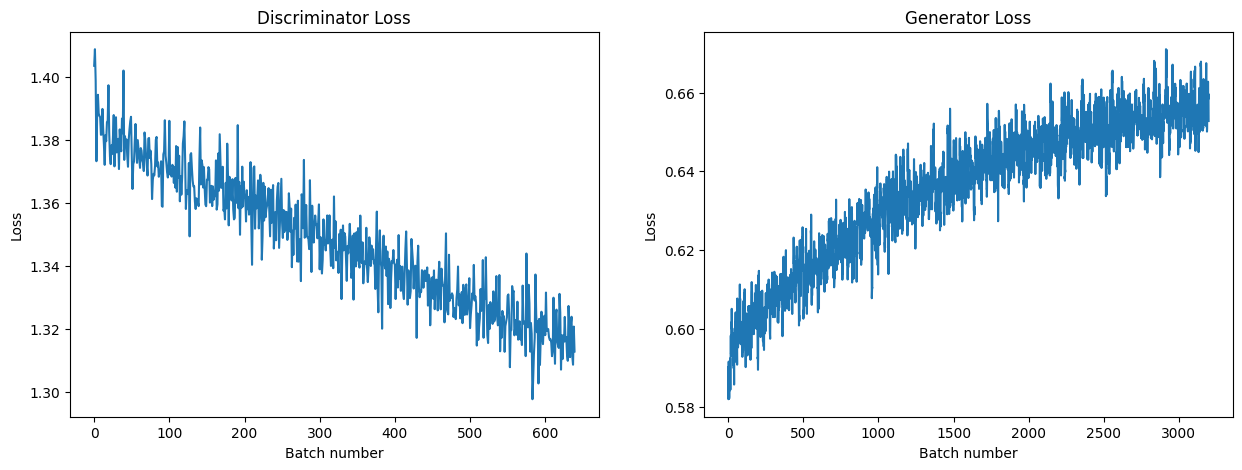

In [ ]:
#Plotting:

plt.figure(figsize=(15, 5))

#Losses:
plt.subplot(1, 2, 1)
plt.plot(D_losses)
plt.title("Discriminator Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses)
plt.title("Generator Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss");

In [ ]:
D_losses_means = []
for i in range(0, len(D_losses), 32):
    chunk = D_losses[i:i+32]
    mean = sum(chunk) / len(chunk)
    D_losses_means.append(mean)

G_losses_means = []
for i in range(0, len(G_losses), 32):
    chunk = G_losses[i:i+32]
    mean = sum(chunk) / len(chunk)
    G_losses_means.append(mean)

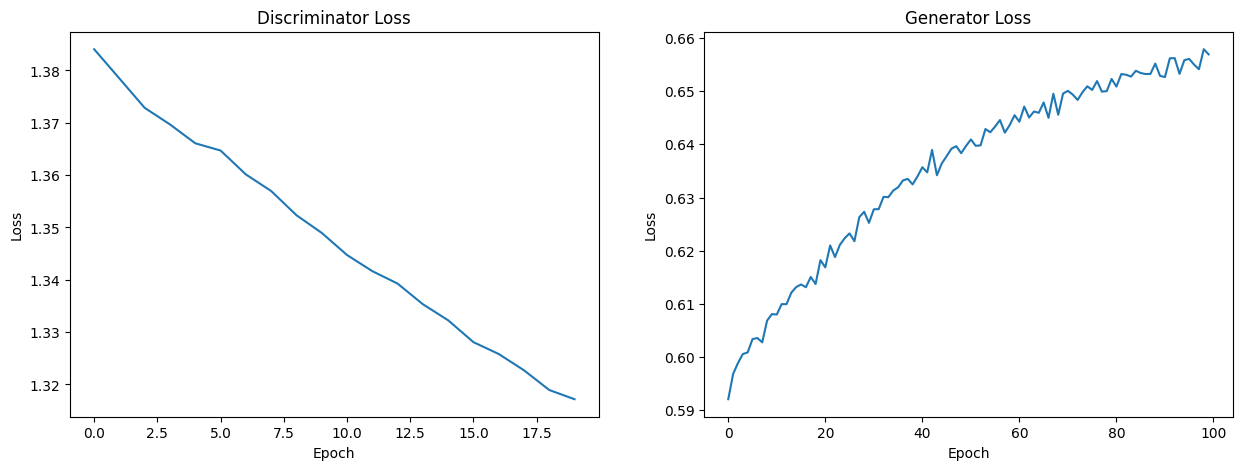

In [ ]:
#Plotting:

plt.figure(figsize=(15, 5))

#Losses:
plt.subplot(1, 2, 1)
plt.plot(D_losses_means)
plt.title("Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses_means)
plt.title("Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss");

##Inference

In [ ]:
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')

In [ ]:
def read_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256))
    image = torch.Tensor(image)

    return image

In [ ]:
validation_moving = [read_image(element[1]) for element in test_set]
validation_fixed = [read_image(element[0]) for element in test_set]

In [ ]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_time = time.time()

fixed = []
moving = []

registered = []
deforms = []

test_generator = data.DataLoader(test_data, batch_size=1, shuffle=True)

for batch_fixed, batch_moving in test_generator:

    fixed.append(batch_fixed)
    moving.append(batch_moving)

    batch_fixed = batch_fixed.unsqueeze(3).to(device)
    batch_moving = batch_moving.unsqueeze(3).to(device)

    val_registered, defor = G(batch_moving, batch_fixed)

    registered.append(val_registered)
    deforms.append(defor)

end_time = time.time() - start_time

print(end_time)


1.0233983993530273


Text(0.5, 1.0, 'Moving Image')

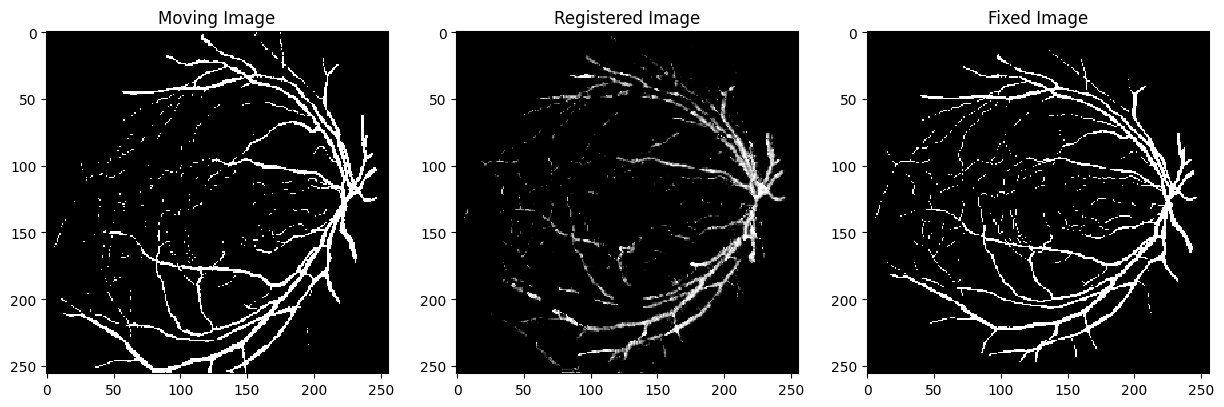

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[31].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[31].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[31].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

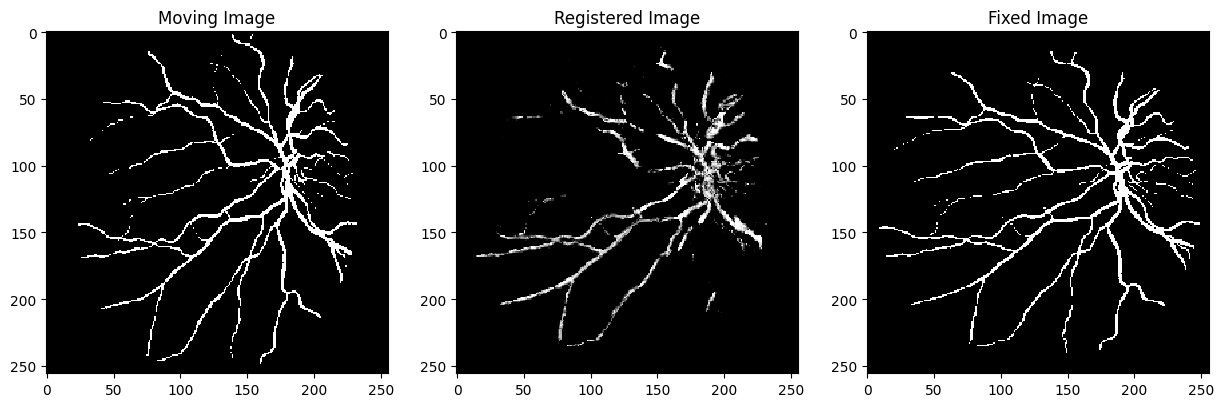

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[78].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[78].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[78].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")


Text(0.5, 1.0, 'Moving Image')

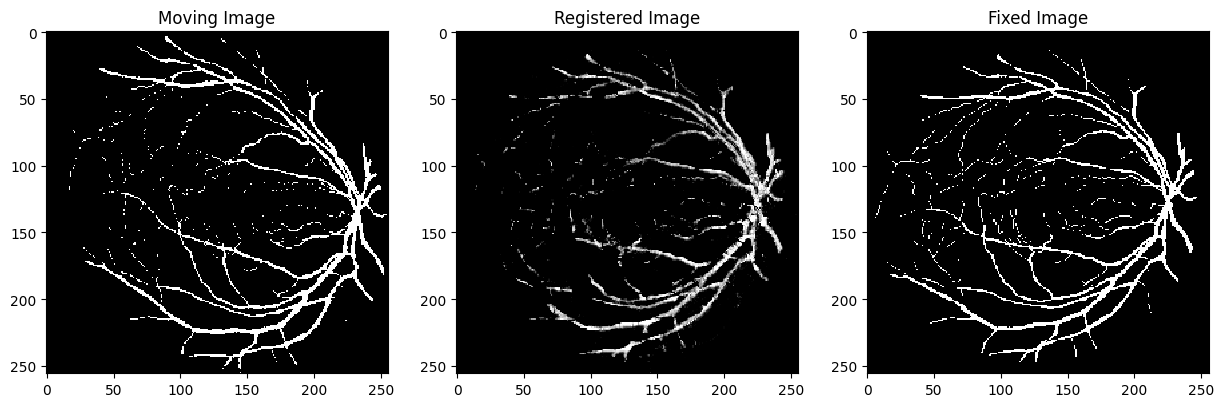

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[32].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[32].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[32].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

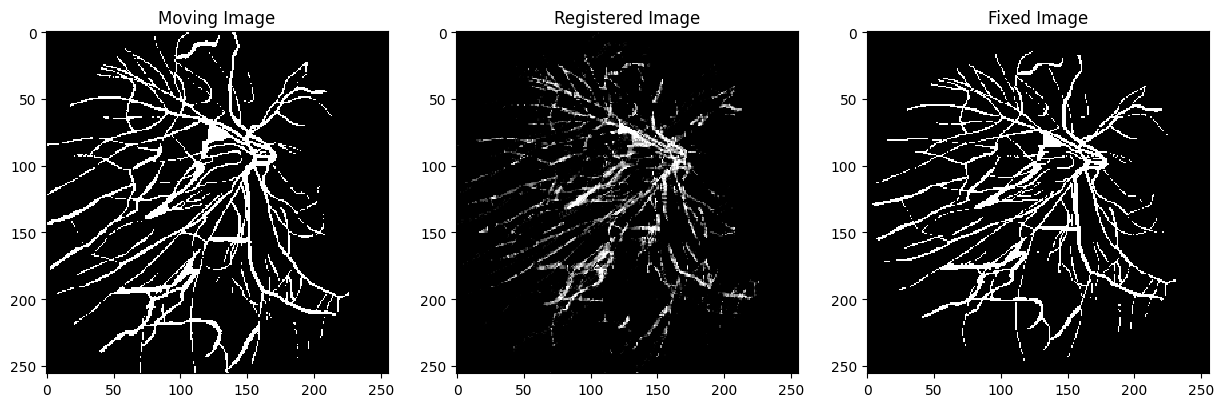

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[22].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[22].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[22].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

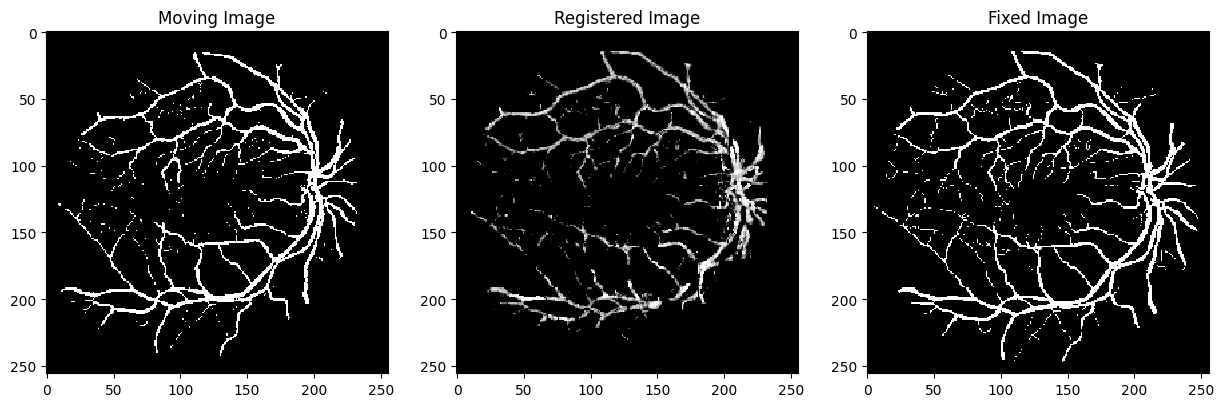

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[11].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[11].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[11].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

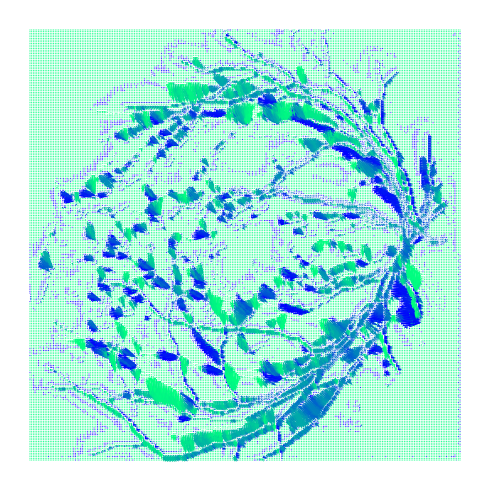

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [ ]:
import neurite as ne
ne.plot.flow([deforms[31].cpu().data.numpy().squeeze()], width = 5)

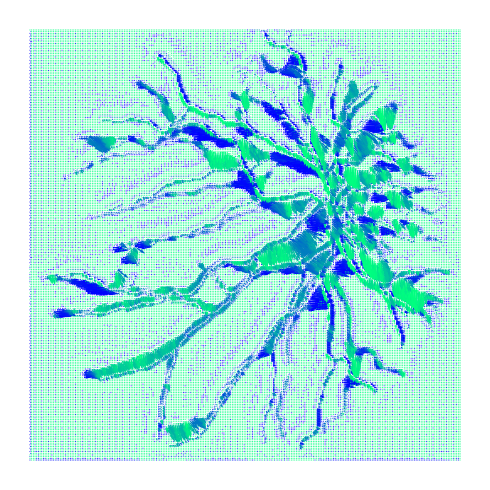

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [ ]:
ne.plot.flow([deforms[78].cpu().data.numpy().squeeze()], width = 5)

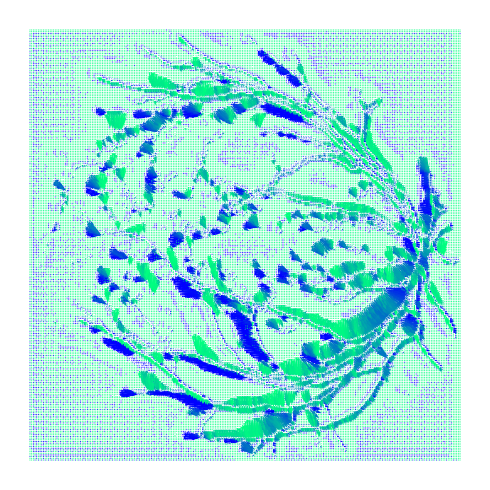

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [ ]:
ne.plot.flow([deforms[32].cpu().data.numpy().squeeze()], width = 5)

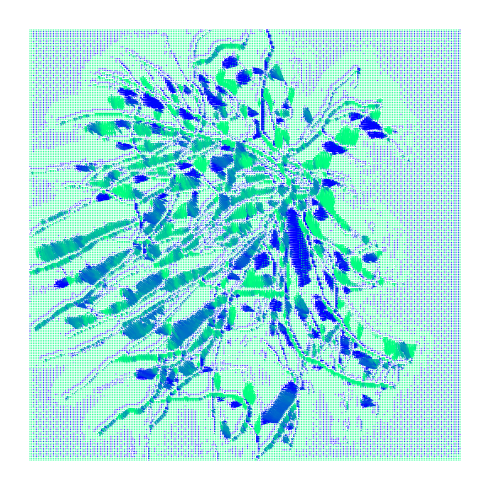

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [ ]:
ne.plot.flow([deforms[22].cpu().data.numpy().squeeze()], width = 5)

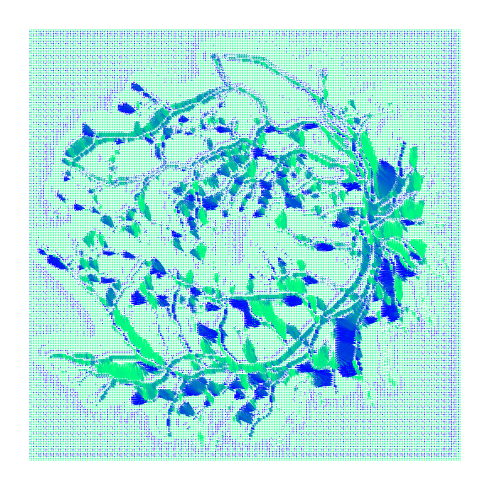

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [ ]:
ne.plot.flow([deforms[11].cpu().data.numpy().squeeze()], width = 5)

In [ ]:
def dice_score(image1, image2, threshold=True):
    # Convert images to grayscale
    if len(image1.shape) > 2:
        image1 = rgb2gray(image1)
    if len(image2.shape) > 2:
        image2 = rgb2gray(image2)

    # Thresholding (if required)
    if threshold:
        threshold_value1 = threshold_otsu(image1)
        threshold_value2 = threshold_otsu(image2)
        image1 = (image1 > threshold_value1).astype(np.uint8)
        image2 = (image2 > threshold_value2).astype(np.uint8)

    # Calculate Dice score
    intersection = np.sum(image1 & image2)
    union = np.sum(image1) + np.sum(image2)
    dice = (2.0 * intersection) / union
    return dice

In [ ]:
def mean_squared_error(image1, image2):
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    mse = np.mean((image1 - image2)**2)
    return mse

In [ ]:
dice_scores = []
mse_scores = []

for idx in range(len(validation_fixed)):
    dice = dice_score(registered[idx].cpu().data.numpy().squeeze(), fixed[idx].cpu().data.numpy().squeeze())
    mse = mean_squared_error(registered[idx].cpu().data.numpy().squeeze(), fixed[idx].cpu().data.numpy().squeeze())

    dice_scores.append(dice)
    mse_scores.append(mse)

In [ ]:
import pandas as pd
metrics = pd.DataFrame(columns=['dice', 'mse'])

metrics['dice'] = dice_scores
metrics['mse'] = mse_scores

In [ ]:
metrics

dice          mse
0   0.575994  3262.776367
1   0.423960  5402.001953
2   0.635735  3126.094238
3   0.691318  2828.663818
4   0.702798  2954.404297
..       ...          ...
75  0.539522  4269.577637
76  0.620734  3055.839844
77  0.532551  3152.189453
78  0.698601  2048.106201
79  0.558170  3276.905273

[80 rows x 2 columns]

In [ ]:
metrics.to_csv('/content/metrics.csv')

In [ ]:
target_train = [pair[0] for pair in train_set]
source_train = [pair[1] for pair in train_set]

In [ ]:
train_split = pd.DataFrame({
    'targets': target_train,
    'sources': source_train
})

In [ ]:
train_split.to_csv('/content/train_split.csv')

In [ ]:
target_val = [pair[0] for pair in validation_set]
source_val = [pair[1] for pair in validation_set]

In [ ]:
val_split = pd.DataFrame({
    'targets': target_val,
    'sources': source_val
})

In [ ]:
val_split.to_csv('/content/val_split.csv')

In [ ]:
target_test = [pair[0] for pair in test_set]
source_test = [pair[1] for pair in test_set]

In [ ]:
test_split = pd.DataFrame({
    'targets': target_test,
    'sources': source_test
})

In [ ]:
test_split.to_csv('/content/test_cplit.csv')

In [ ]:
# !zip -r /content/vm_gan_drive_new.zip /content/vm_gan_drive_new

## INFERENCE FROM LOADED

In [10]:
import neurite as ne

In [11]:
import pandas as pd

In [12]:
G.load_state_dict(torch.load('/Users/nastya/Documents/ucu/thesis/voxelmorph/drive/generator.pth', map_location=torch.device('cpu')))
D.load_state_dict(torch.load('/Users/nastya/Documents/ucu/thesis/voxelmorph/drive/discriminator.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
def read_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256))
    image = torch.Tensor(image)

    return image

In [14]:
test_df = pd.read_csv('/Users/nastya/Documents/ucu/comparison-of-medical-image-registration-methods/data/drive_split/test_split.csv')

DATA_PATH = '/Users/nastya/Documents/ucu/thesis/data/drive_data'

test_set = []
for index, row in test_df.iterrows():
    target_image = row['targets'].replace('/content/drive_data', DATA_PATH)
    source_image = row['sources'].replace('/content/drive_data', DATA_PATH)
    test_set.append((target_image, source_image))

In [15]:
test_data = DriveDataset(test_set)

In [16]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_time = time.time()

fixed = []
moving = []

registered = []
deforms = []

test_generator = data.DataLoader(test_data, batch_size=1, shuffle=False)

for batch_fixed, batch_moving in tqdm(test_generator):

    fixed.append(batch_fixed)
    moving.append(batch_moving)

    batch_fixed = batch_fixed.unsqueeze(3).to(device)
    batch_moving = batch_moving.unsqueeze(3).to(device)

    val_registered, defor = G(batch_moving, batch_fixed)

    registered.append(val_registered)
    deforms.append(defor)

end_time = time.time() - start_time

print(end_time)

100%|██████████| 80/80 [00:16<00:00,  4.88it/s]

16.40276598930359


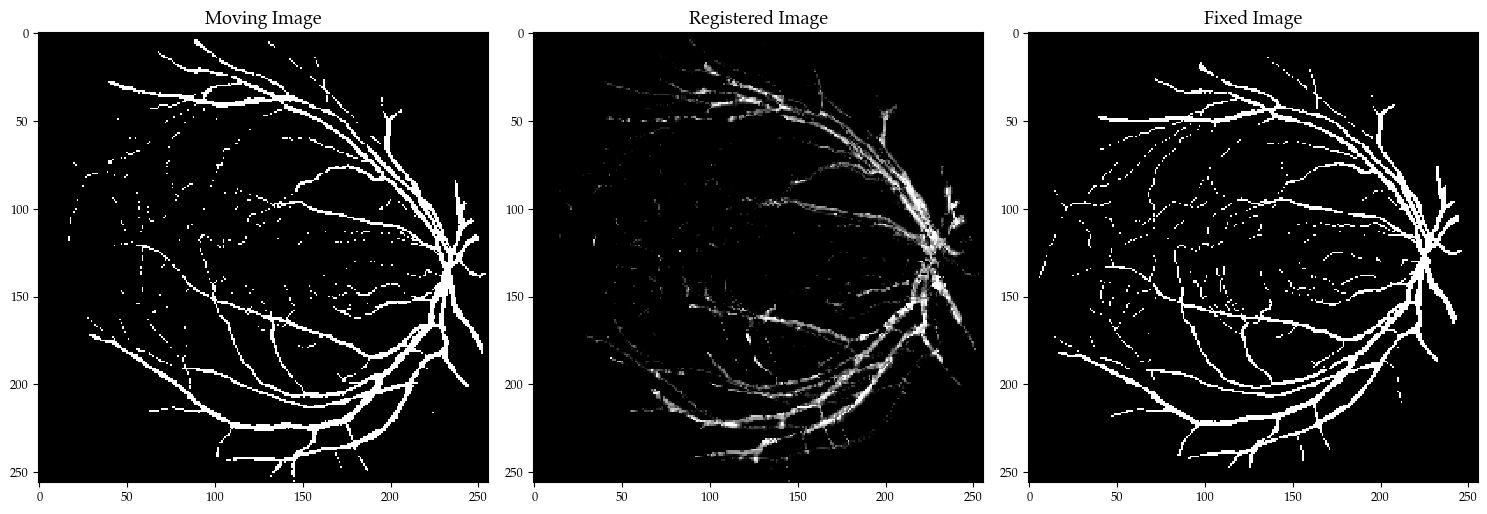

In [25]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[78].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(fixed[78].detach().numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(moving[78].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)

plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

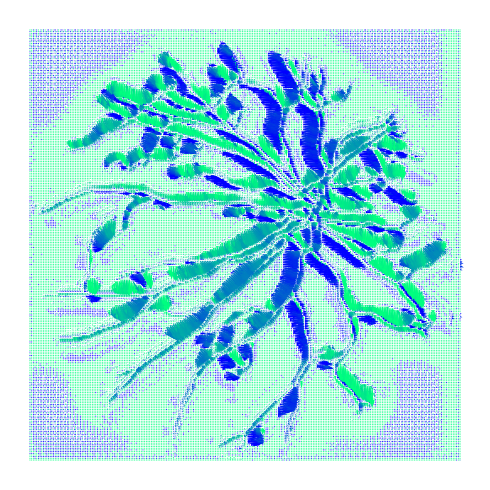

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [ ]:
ne.plot.flow([defors[0].cpu().data.numpy().squeeze()], width = 5)

## METRICS

In [18]:
def dice_score(image1, image2, threshold=True):
    # Convert images to grayscale
    if len(image1.shape) > 2:
        image1 = rgb2gray(image1)
    if len(image2.shape) > 2:
        image2 = rgb2gray(image2)

    # Thresholding (if required)
    if threshold:
        threshold_value1 = threshold_otsu(image1)
        threshold_value2 = threshold_otsu(image2)
        image1 = (image1 > threshold_value1).astype(np.uint8)
        image2 = (image2 > threshold_value2).astype(np.uint8)

    # Calculate Dice score
    intersection = np.sum(image1 & image2)
    union = np.sum(image1) + np.sum(image2)
    dice = (2.0 * intersection) / union
    return dice

In [19]:
def mean_squared_error(image1, image2):
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    mse = np.mean((image1 - image2)**2)
    return mse

In [21]:
dice_scores = []
mse_scores = []

for idx in range(len(registered)):

    registered_float = registered[idx].cpu().data.numpy().squeeze().astype(np.float64) / 255.0
    fixed_float = fixed[idx].cpu().data.numpy().squeeze().astype(np.float64) / 255.0

    dice = dice_score(registered_float, fixed_float)
    mse = mean_squared_error(registered_float, fixed_float)

    dice_scores.append(dice)
    mse_scores.append(mse)

In [22]:
import pandas as pd

metrics_data = pd.DataFrame({
    'dice': dice_scores,
    'mse': mse_scores
})

In [23]:
metrics_data

dice       mse
0   0.528076  0.048395
1   0.607997  0.052253
2   0.738251  0.041126
3   0.475057  0.063664
4   0.690258  0.041696
..       ...       ...
75  0.553284  0.070507
76  0.623914  0.043132
77  0.662549  0.049997
78  0.816708  0.026870
79  0.693484  0.054400

[80 rows x 2 columns]

In [24]:
metrics_data['mse'].mean()

0.04637048907078723

In [25]:
metrics_data['dice'].mean()

0.6416588832794621

In [26]:
metrics_data.to_csv('voxelmorph_gan_drive_metrics.csv', index=False)

In [27]:
import pickle

with open('/Users/nastya/Documents/ucu/thesis/voxelmorph/inference_drive/registered.pkl', 'wb') as f:
    pickle.dump(registered, f)

In [ ]:
# !zip -r /content/voxelmorph_gan_drive_inference.zip /content/voxelmorph_gan_drive_inference